In [ ]:
# %%
"""
# NMME Marine Heat Wave
 
The script calculate the HCI value from the start of the nmme 1991 based on 
Brodie et al., [2023]

Using NMME model hindcast and forecast obtained from 
http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/
with variable SST

"""


# %%
# start a local cluster
import json
import subprocess
from datetime import date
import warnings
import xarray as xr
from dask.distributed import Client
from nmme_download import iri_nmme_models
from nmme_hci_climo_threshold import read_marine_index_mask
from nmme_monthly_mhw import read_nmme_onlist, output_format

warnings.simplefilter("ignore")


if __name__ == "__main__":

    warnings.filterwarnings("ignore")

    ### open local cluster
    client = Client(n_workers=2,threads_per_worker=60,processes=False)

    ###### Setting ######
    # specify date
    today = date.today()
    # setup the new output file name (same as date of download)
    dateform = today.strftime("%y_%m_%d")

    # directory where new simulation (inputs) and mhw forecast (outputs) is located
    BASEDIR = '/Datasets.private/marinehw/nmme_sst_raw/'

    # directory where sst threshold/climatology/trend (inputs) is located
    PREDIR = '/Datasets.private/marinehw/nmme_sst_stat/'

    # directory where nmme mhw probability is located
    OUTDIR = '/Datasets.private/marinehw/nmme_mhw_prob/'

    # directory where the marine index mask is located
    MASKDIR = '/Datasets.private/marinehw/nmme_marine_index_mask/'

    # output filename date, MHW prediction generated date
    date = dateform

    # used model list
    with open('model_use_list.json','r',encoding='utf-8') as f:
        json_dict = json.load(f)
    model_use_list = json_dict['model_use_list']

    dict_model = iri_nmme_models()
    avai_model_list = list(dict_model.keys())

    ################################## Main program start #####################################

    dict_da = read_nmme_onlist(model_use_list,avai_model_list,BASEDIR,PREDIR,start_year=1991)

    ds_mask = read_marine_index_mask(MASKDIR)

    


In [ ]:
da_hci_list = []
model_use_list = ['CanCM4i-IC3']
for nmodel,model in enumerate(model_use_list):
    if model in avai_model_list:
        threshold_file = f'{PREDIR}{model}_climo_threshold_hci.nc'

        print('------------')
        print(model,' HCI detection...')
        print('------------')

        # read threshold (1991-2020)
        da_threshold = xr.open_dataset(
            threshold_file,
            chunks={'S':1,'L':1}
        )['hci_threshold']

        da_sst = ds_mask['HCI_150km']*dict_da['da_model_list'][nmodel]

        print('calculating HCI')
        da_hci = da_sst.where(da_sst.groupby('S.month')<=da_threshold)
        da_hci = (
            da_hci
            .where(da_hci.isnull(),other=1)
            .sum(dim=['M','X','Y'],skipna=True)
        )
        da_hci_list.append(da_hci)




In [ ]:

# total grid points lower than threshold (all ensemble and models)
da_hci_all = xr.concat(da_hci_list,dim='model',join='outer')
da_hci_all_out = (da_hci_all**dict_da['da_allmodel_mask']).sum(dim='model').compute()

# calculate total grid points in the 150km region
da_total_grids = (
    dict_da['da_nmem_all_out'].sum(dim=['X','Y'],skipna=True)*
    (ds_mask['HCI_150km']*dict_da['da_allmodel_mask']).sum(dim=['X','Y'],skipna=True)
)


ds_hci_ratio = xr.Dataset()
ds_hci_ratio['hci'] = da_hci_all_out/da_total_grids

In [1]:
import xarray as xr
ds_hci = xr.open_dataset('/Datasets.private/marinehw/nmme_mhw_prob/nmme_hci_latest.nc')

In [7]:
ds_hci

<xarray.Dataset>
Dimensions:     (lead_time: 12, start_time: 401)
Coordinates:
  * lead_time   (lead_time) float32 0.5 1.5 2.5 3.5 4.5 ... 8.5 9.5 10.5 11.5
  * start_time  (start_time) datetime64[ns] 1991-01-01 1991-02-01 ... 2024-05-01
Data variables:
    hci         (start_time, lead_time) float32 ...
Attributes:
    title:      ['HCI derived from  CanCM4i-IC3', 'HCI derived from  GEM5-NEM...
    comment:    Derived at NOAA Physical Science Laboratory
    reference:  Brodie et al., 2023, https://doi.org/10.1038/s41467-023-43188-0

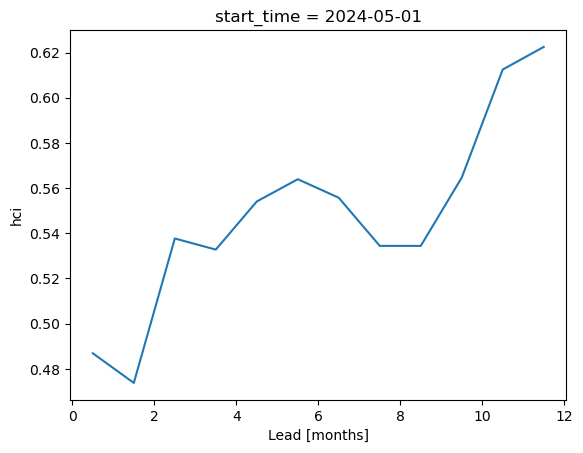

In [8]:
ds_hci.isel(start_time=-1).hci.plot()

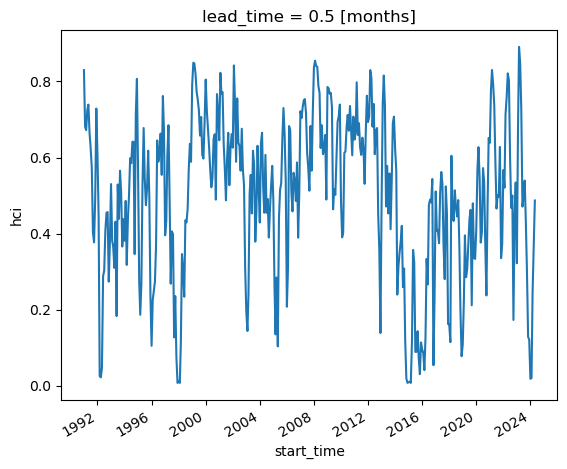

In [9]:
ds_hci.isel(lead_time=0).hci.plot()

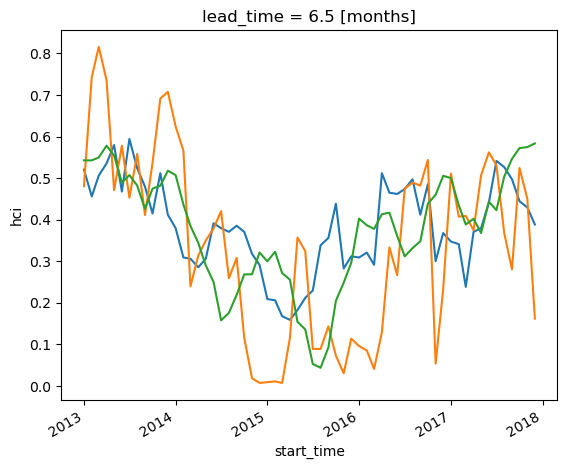

In [12]:
ds_hci.isel(lead_time=11).sel(start_time=slice('2013-01','2017-12')).hci.plot()
ds_hci.isel(lead_time=0).sel(start_time=slice('2013-01','2017-12')).hci.plot()
ds_hci.isel(lead_time=6).sel(start_time=slice('2013-01','2017-12')).hci.plot()
